In [1]:
from IPython.display import clear_output
!pip3 install tensorflow_addons
clear_output()

In [2]:
import sys
sys.path.append('/home/jovyan/ChestXray-14')

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

from modules.utils import get_dataset
from modules.dataset import LABELS

2023-03-22 16:01:46.318858: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
import os
CURRENT_PATH = os.path.abspath("")
CURRENT_PATH

'/home/jovyan/ChestXray-14/experiments/Under Sampling for compare with best model'

In [5]:
RESULT_EVALUATE_PATH = os.path.join(CURRENT_PATH, "results", "evaluate", "cross_entropy", "EfficientNetB0_None")
RESULT_EVALUATE_PATH

'/home/jovyan/ChestXray-14/experiments/Under Sampling for compare with best model/results/evaluate/cross_entropy/EfficientNetB0_None'

In [6]:
from pathlib import Path
Path(RESULT_EVALUATE_PATH).mkdir(parents=True, exist_ok=True)

In [7]:
class Dataset:
    INPUT_PATH = "/home/jovyan/ChestXray-14/dataset/ChestXray NIH"
    
    def get_train(self):
        filenames = tf.io.gfile.glob(f'{self.INPUT_PATH}/data/Under_Sampling_on_fold_3_dataset/train/*.tfrec')
        dataset = get_dataset(filenames)
        return dataset

    def get_test(self):
        filenames = tf.io.gfile.glob(f'{self.INPUT_PATH}/data/Under_Sampling_on_fold_3_dataset/test/*.tfrec')
        dataset = get_dataset(filenames)
        return dataset

In [8]:
test_dataset = Dataset().get_test()

2023-03-22 16:01:48.658224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 16:01:50.326365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31661 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:17:00.0, compute capability: 8.0


## Experiment

In [9]:
ROOT_PATH = "/home/jovyan/ChestXray-14"
num_class = 15 # TODO: change to 15 for multi-labels

In [10]:
from sklearn import metrics
from functools import partial
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt

import pdb

class Evaluate_AUC:
    def __init__(self, model_path):
        self.y_true = None
        self.y_preds = None
        self.model_path = model_path
        self.model = self.get_model(self.model_path)
        self.df_metrics = None
        
    def get_model(self, path):
        return tf.keras.models.load_model(path)
    
    def get_y_true(self, data):
        y_true=[]
        for X,y in data:
            for label in y:
                y_true.append(label)
        y_true = tf.Variable(y_true)
        self.y_true = y_true
        return y_true
    
    def model_predict(self, test_dataset):
        return self.model.predict(test_dataset)
    
    def _load_predict_and_actual(self):
        self.y_true = self.get_y_true(test_dataset)
        self.y_preds = self.model_predict(test_dataset)
        
    def auc(self, y_true=None, y_preds=None):
        m = tf.keras.metrics.AUC(multi_label=True, num_thresholds=200)
        if y_true is None:
            y_true = self.y_true
        if y_preds is None:
            y_preds = self.y_preds
        m.update_state(y_true, y_preds)
        thresholds = m._thresholds
        true_positives, true_negatives, false_positives, false_negatives = m.variables
        
        df = pd.DataFrame({
            "thresholds": thresholds,
            "TP": true_positives,
            "TN": true_negatives,
            "FP": false_positives,
            "FN": false_negatives
        })
        
        df = df.apply({"thresholds": lambda x: x,
                   "TP": lambda x: x.numpy().tolist(),
                   "TN": lambda x: x.numpy().tolist(),
                   "FP": lambda x: x.numpy().tolist(),
                   "FN": lambda x: x.numpy().tolist()})
        
        self.df_metrics = df
        # pdb.set_trace()
        print("AUC:", m.result().numpy())
        
    def preprocessing(self, x, label=0):
        return np.array(x)[label]

    def drop_duplicates(self, tpr, fpr):
        df = pd.DataFrame({
            "TPR": tpr,
            "FPR": fpr
        })
        df = df.drop_duplicates()
        return df["TPR"].values, df["FPR"].values

    def get_tpr_fpr(self, index):
        func = partial(self.preprocessing, label=index)

        TP = self.df_metrics["TP"].apply(func)
        TN = self.df_metrics["TN"].apply(func)
        FP = self.df_metrics["FP"].apply(func)
        FN = self.df_metrics["FN"].apply(func)

        tpr = TP / (TP + FN)
        fpr = FP / (FP + TN)

        tpr, fpr = self.drop_duplicates(tpr, fpr)
        return tpr, fpr
    
    def plot_auc(self):
        label_index = 0
        sns.set_theme()
        plt.figure(figsize=(12, 6))

        auc_list = []
        for i in range(15):
            tpr, fpr = self.get_tpr_fpr(i)
            sns.lineplot(
                x=fpr,
                y=tpr,
                linewidth=2,
                label=f"Class {i+1}"
            )

            # Draw Rectangle
            for idx, x in enumerate(fpr[:-1]):
                rect=mpatches.Rectangle(xy=(x,0),
                                        width=fpr[idx+1] - x,
                                        height=(tpr[idx] + tpr[idx+1])/2,
                                        fill = False,
                                        color = "purple",
                                        linewidth = 0.2)
                plt.gca().add_patch(rect)


            delta = (tpr[1:] + tpr[:-1]) /2
            distance = abs(fpr[1:] - fpr[:-1])
            auc = sum(delta * distance)
            auc_list.append(auc)

            print(f"Class {i+1}: {auc}")
            sns.scatterplot(x=fpr, y=tpr, s=50, marker="o")
            # break

        self.auc_list = auc_list
        self.auc_avg = np.mean(auc_list)
        print(f"Average AUC: {np.mean(auc_list)}")
        sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="red")
        plt.xlabel("FPR")
        plt.ylabel("TPR");
        
    def to_csv(self, path):
        df = pd.DataFrame({key:[value] for key, value in zip(LABELS, self.auc_list)})
        df.to_csv(path, index=False)


## Using

In [11]:
MODEL_PATH = f'{CURRENT_PATH}/results/models/cross_entropy/EfficientNetB0_None.h5'
best_model = Evaluate_AUC(MODEL_PATH)

In [12]:
best_model._load_predict_and_actual()

2023-03-22 16:02:07.649335: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-03-22 16:02:08.699758: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-22 16:02:08.700655: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-22 16:02:08.700679: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-22 16:02:08.701532: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-22 16:02:08.701591: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


      7/Unknown - 8s 22ms/step

2023-03-22 16:02:12.942795: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1402/1402 [==============================] - 47s 28ms/step


AUC: 0.7344055
Class 1: 0.726631598664101
Class 2: 0.7412189667744721
Class 3: 0.767082618819219
Class 4: 0.6320131852689508
Class 5: 0.7841927951985371
Class 6: 0.8598074550813207
Class 7: 0.7536069173695163
Class 8: 0.6962848988467363
Class 9: 0.819154465183011
Class 10: 0.6805750190025003
Class 11: 0.7221642620826083
Class 12: 0.842121557647649
Class 13: 0.5818970737392747
Class 14: 0.7071942265623448
Class 15: 0.7021375448706487
Average AUC: 0.7344055056740594


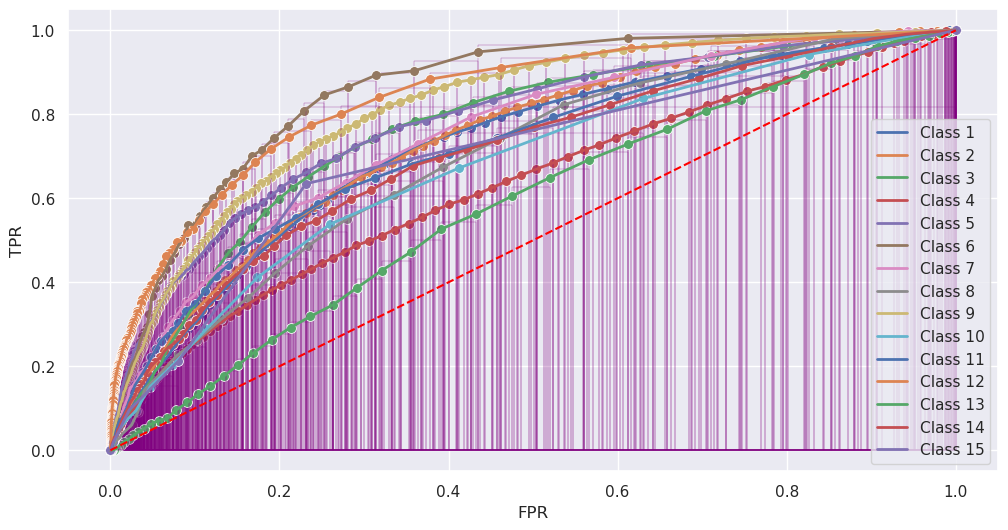

In [13]:
best_model.auc()
best_model.plot_auc()
best_model.to_csv(f"{RESULT_EVALUATE_PATH}/auc.csv")